In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
pd.set_option('display.max_columns', None)
from IPython.display import display
import lightgbm as lgb
import numpy as np
import optuna
from joblib import dump

optuna.logging.set_verbosity(optuna.logging.DEBUG)

data = pd.read_parquet("house_price_data_20-05-2024.parquet")
data.drop_duplicates(subset="link")

,Unnamed: 0,district,municipality,parish,neighborhood,neighborhood_link,title,link,description,garage,price,home_type,date,source_link,home_size,home_area,floor,elevator,price_per_sqr_meter
0,148,NaN,albufeira,albufeira e olhos de agua,branqueira brejos,https://www.idealista.pt/arrendar-casas/albufe...,"Apartamento T2 em Branqueira - Brejos, Albufei...",https://www.idealista.pt/imovel/33378178/,"Indulge in opulence within this 2022-built, 2-...",True,2800,Apartamento,2024-05-20,https://www.idealista.pt/arrendar-casas/albufe...,T2,158,2,False,17.721519
2,143,NaN,albufeira,albufeira e olhos de agua,centro da cidade,https://www.idealista.pt/arrendar-casas/albufe...,"Moradia independente em Centro da Cidade, Albu...",https://www.idealista.pt/imovel/33325917/,Inserido num Lote de 317 m² e a contar com 2 a...,True,2200,Moradia,2024-05-20,https://www.idealista.pt/arrendar-casas/albufe...,T3,196,0,False,11.224490
4,143,NaN,albufeira,albufeira e olhos de agua,centro da cidade,https://www.idealista.pt/arrendar-casas/albufe...,"Apartamento T4 em Centro da Cidade, Albufeira,...",https://www.idealista.pt/imovel/33406568/,Apartamento T4 Penthouse situado no último and...,True,8000,Apartamento,2024-05-20,https://www.idealista.pt/arrendar-casas/albufe...,T4,500,0,False,16.000000
6,143,NaN,albufeira,albufeira e olhos de agua,centro da cidade,https://www.idealista.pt/arrendar-casas/albufe...,"Penthouse na rua do oceano, 3, Centro da Cidad...",https://www.idealista.pt/imovel/32996295/,Cobertura de luxo totalmente mobiliada e equip...,True,3875,Penthouse,2024-05-20,https://www.idealista.pt/arrendar-casas/albufe...,T2,209,2,False,18.540670
8,156,NaN,albufeira,albufeira,correeira,https://www.idealista.pt/arrendar-casas/albufe...,"Moradia geminada no beco Correeiro, Correeira,...",https://www.idealista.pt/imovel/33113837/,Arrendamento ao ANO Ampla moradia com 3 quarto...,True,3900,Moradia,2024-05-20,https://www.idealista.pt/arrendar-casas/albufe...,T3,332,0,False,11.746988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,537,NaN,viseu,viseu,marzovelos jugueiros,https://www.idealista.pt/arrendar-casas/viseu/...,"Apartamento T3 na rua António Góis Guerreiro, ...",https://www.idealista.pt/imovel/33358685/,<NA>,True,1200,Apartamento,2024-05-20,https://www.idealista.pt/arrendar-casas/viseu/...,T3,100,5,True,12.000000
6354,538,NaN,viseu,viseu,zona historica,https://www.idealista.pt/arrendar-casas/viseu/...,"Moradia em banda, viseu, Zona Histórica, Viseu",https://www.idealista.pt/imovel/33406259/,Arrenda-se moradia V3 em Repeses - Viseu. O im...,True,800,Moradia,2024-05-20,https://www.idealista.pt/arrendar-casas/viseu/...,T3,120,0,False,6.666667
6355,538,NaN,viseu,viseu,zona historica,https://www.idealista.pt/arrendar-casas/viseu/...,"Apartamento T3 na rua Senhora da Boa Morte, 32...",https://www.idealista.pt/imovel/33095614/,"No Centro Histórico de Viseu, junto à Sé. Aloj...",True,980,Apartamento,2024-05-20,https://www.idealista.pt/arrendar-casas/viseu/...,T3,80,0,False,12.250000
6356,538,NaN,viseu,viseu,zona historica,https://www.idealista.pt/arrendar-casas/viseu/...,"Apartamento T1 na rua dos Loureiros, 5, Zona H...",https://www.idealista.pt/imovel/32582455/,"Arrendo T 1 O título do anúncio tem lapso, o a...",True,600,Apartamento,2024-05-20,https://www.idealista.pt/arrendar-casas/viseu/...,T1,75,2,True,8.000000


In [4]:
selected_features = ["home_type", "garage", "home_size", "floor", "elevator", "neighborhood", "home_area", "parish", "municipality"]
target = ["price"]

data = data[selected_features + target]

In [5]:
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type == 'bool' or col_type == 'string':
        data[c] = data[c].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6358 entries, 0 to 6357
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   home_type     6358 non-null   category
 1   garage        6358 non-null   category
 2   home_size     6358 non-null   category
 3   floor         6358 non-null   int32   
 4   elevator      6358 non-null   category
 5   neighborhood  6358 non-null   category
 6   home_area     6358 non-null   int32   
 7   parish        6358 non-null   category
 8   municipality  6358 non-null   category
 9   price         6358 non-null   int32   
dtypes: category(7), int32(3)
memory usage: 148.8 KB


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target), 
                                                    data[target], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [7]:
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test)

from optuna.integration import LightGBMTuner
optuna.logging.set_verbosity(0)

def tune_hyperparameters(d_train, d_valid):
    params = {
        'objective': 'tweedie',  # or 'tweedie' or any other suitable according to your task
        'metric': 'rmse',           # Evaluation metric
        'boosting_type': 'gbdt', 
        'verbosity': 0   # Default boosting type
    }

    # Creating the tuner
    tuner = LightGBMTuner(params, 
                          d_train,
                          valid_sets=[d_valid],
                          num_boost_round=1000,
                          show_progress_bar = True)  # Maximum number of boosting iterations

    # Running the tuning
    tuner.run()

    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    best_booster = tuner.get_best_booster()

    return best_params, best_booster

best_params, best_booster = tune_hyperparameters(d_train, d_valid)
dump(best_booster, 'model.joblib')


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


feature_fraction, val_score: 1100.418049:  14%|#4        | 1/7 [00:01<00:10,  1.72s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction, val_score: 980.023682:  29%|##8       | 2/7 [00:03<00:07,  1.55s/it] 

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction, val_score: 971.291816:  43%|####2     | 3/7 [00:04<00:06,  1.55s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction, val_score: 971.291816:  57%|#####7    | 4/7 [00:06<00:04,  1.50s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction, val_score: 971.291816:  71%|#######1  | 5/7 [00:07<00:03,  1.54s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction, val_score: 971.291816:  86%|########5 | 6/7 [00:09<00:01,  1.53s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

num_leaves, val_score: 971.291816:   5%|5         | 1/20 [00:06<01:58,  6.26s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

num_leaves, val_score: 971.291816:  10%|#         | 2/20 [00:13<02:00,  6.69s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  15%|#5        | 3/20 [00:19<01:51,  6.58s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  20%|##        | 4/20 [00:20<01:08,  4.26s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  25%|##5       | 5/20 [00:25<01:06,  4.46s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  30%|###       | 6/20 [00:30<01:04,  4.58s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  35%|###5      | 7/20 [00:36<01:05,  5.07s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  40%|####      | 8/20 [00:39<00:54,  4.52s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  45%|####5     | 9/20 [00:41<00:41,  3.77s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  50%|#####     | 10/20 [00:44<00:35,  3.59s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  55%|#####5    | 11/20 [00:48<00:31,  3.49s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  60%|######    | 12/20 [00:48<00:20,  2.62s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 971.291816:  65%|######5   | 13/20 [00:54<00:25,  3.59s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  70%|#######   | 14/20 [00:56<00:18,  3.17s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

num_leaves, val_score: 971.291816:  75%|#######5  | 15/20 [01:02<00:20,  4.00s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  80%|########  | 16/20 [01:08<00:17,  4.45s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  85%|########5 | 17/20 [01:11<00:12,  4.28s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

num_leaves, val_score: 971.291816:  90%|######### | 18/20 [01:17<00:09,  4.77s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


num_leaves, val_score: 971.291816:  95%|#########5| 19/20 [01:23<00:04,  4.96s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  10%|#         | 1/10 [00:01<00:14,  1.61s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  20%|##        | 2/10 [00:03<00:13,  1.64s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  30%|###       | 3/10 [00:04<00:11,  1.62s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  40%|####      | 4/10 [00:06<00:09,  1.58s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  50%|#####     | 5/10 [00:07<00:07,  1.59s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  60%|######    | 6/10 [00:09<00:06,  1.58s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  70%|#######   | 7/10 [00:11<00:04,  1.58s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  80%|########  | 8/10 [00:12<00:03,  1.59s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


bagging, val_score: 971.291816:  90%|######### | 9/10 [00:14<00:01,  1.58s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction_stage2, val_score: 971.291816:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction_stage2, val_score: 971.291816:  33%|###3      | 1/3 [00:01<00:02,  1.33s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


feature_fraction_stage2, val_score: 971.291816:  67%|######6   | 2/3 [00:02<00:01,  1.38s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:   5%|5         | 1/20 [00:01<00:27,  1.45s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  10%|#         | 2/20 [00:02<00:25,  1.41s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  15%|#5        | 3/20 [00:04<00:24,  1.44s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  20%|##        | 4/20 [00:05<00:22,  1.43s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  25%|##5       | 5/20 [00:07<00:21,  1.41s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  30%|###       | 6/20 [00:08<00:19,  1.41s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  35%|###5      | 7/20 [00:09<00:18,  1.40s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  40%|####      | 8/20 [00:11<00:17,  1.44s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291816:  45%|####5     | 9/20 [00:12<00:15,  1.43s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291807:  50%|#####     | 10/20 [00:14<00:14,  1.41s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291803:  55%|#####5    | 11/20 [00:15<00:12,  1.42s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291803:  60%|######    | 12/20 [00:16<00:11,  1.40s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291803:  65%|######5   | 13/20 [00:18<00:09,  1.41s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291798:  70%|#######   | 14/20 [00:19<00:08,  1.41s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291798:  75%|#######5  | 15/20 [00:21<00:07,  1.42s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291798:  80%|########  | 16/20 [00:22<00:05,  1.44s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291798:  85%|########5 | 17/20 [00:24<00:04,  1.43s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291798:  90%|######### | 18/20 [00:25<00:02,  1.44s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


regularization_factors, val_score: 971.291798:  95%|#########5| 19/20 [00:27<00:01,  1.44s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


min_child_samples, val_score: 971.291798:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


min_child_samples, val_score: 971.291798:  20%|##        | 1/5 [00:01<00:05,  1.28s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


min_child_samples, val_score: 971.291798:  40%|####      | 2/5 [00:03<00:04,  1.56s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


min_child_samples, val_score: 971.291798:  60%|######    | 3/5 [00:04<00:03,  1.53s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


min_child_samples, val_score: 953.312208:  80%|########  | 4/5 [00:05<00:01,  1.43s/it]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


min_child_samples, val_score: 953.312208: 100%|##########| 5/5 [00:07<00:00,  1.48s/it]

Best score: 953.3122078631995
Best params: {'objective': 'tweedie', 'metric': 'rmse', 'boosting_type': 'gbdt', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 1.3789238812532874e-06, 'lambda_l2': 0.002757543165012161, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10}


['model.joblib']

In [8]:
def regression_scores(y_test, y_pred):
    scores = {}
    scores['mean_squared_error'] = mean_squared_error(y_test, y_pred)
    scores['root_mean_squared_error'] = mean_squared_error(y_test, y_pred, squared=False)
    scores['mean_absolute_error'] = mean_absolute_error(y_test, y_pred)
    scores['median_absolute_error'] = median_absolute_error(y_test, y_pred)
    scores['r2_score'] = r2_score(y_test, y_pred)
    scores['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, y_pred)
    scores['explained_variance_score'] = explained_variance_score(y_test, y_pred)
    scores['max_error'] = max_error(y_test, y_pred)

    return scores


In [9]:
def train_and_evaluate(X_test, y_test, best_model):

    # Predicting the test set results
    y_pred = best_model.predict(X_test)

    # Evaluating the predictions
    scores = regression_scores(y_test, y_pred)
    return scores

Text(0.5, 1.0, 'Actual vs. Predicted')

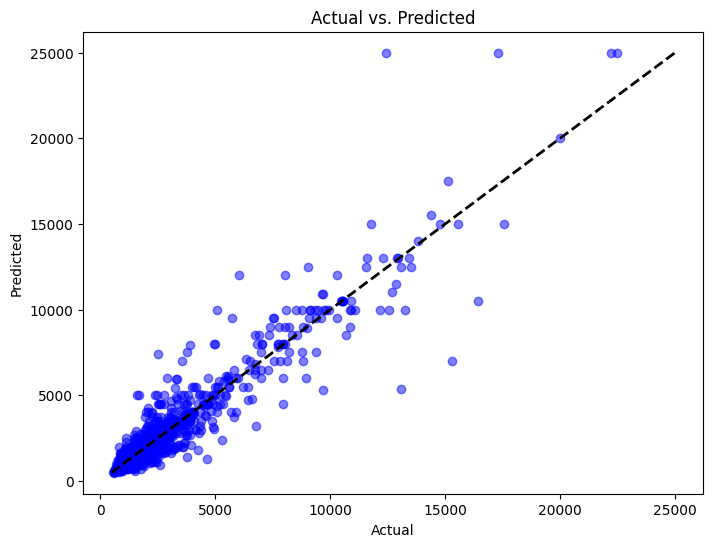

In [11]:
import matplotlib.pyplot as plt

y_pred = best_booster.predict(X_test)

# y_pred/y_test QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

NameError: name 'plt' is not defined

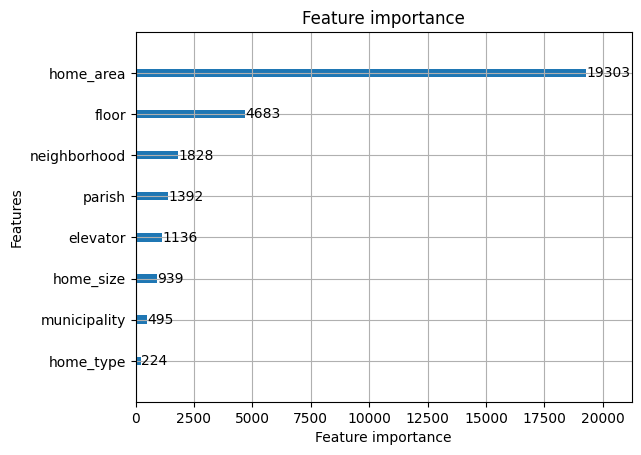

In [10]:
ax = lgb.plot_importance(best_booster, max_num_features=10)
plt.show()


In [ ]:
scores = train_and_evaluate(X_test, y_test, best_booster)
display(scores)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'mean_squared_error': 604752.1159048319,
 'root_mean_squared_error': 777.6580970483313,
 'mean_absolute_error': 371.83376146174726,
 'median_absolute_error': 150.9659638289437,
 'r2_score': 0.8393410698632285,
 'mean_absolute_percentage_error': 0.1642133489328092,
 'explained_variance_score': 0.8395290574648101,
 'max_error': 8015.6627059216735}